# Objective
Show that
$$\mathbb{V}_D\left[\frac{1}{nt} \sum_{i}\sum_j \mathbb{V}[\hat Y_{ij}^s|D]\right] = \frac{1}{nt^2}\mathbb{V}_{D_i}\left[\sum_j \mathbb{V}[\hat Y^s_{ij}|D_i]\right]$$
for $|D| = n$.

In [1]:
from utils import *

## Preliminary
First check this not for the variance but some random variable (here Gaussian) that depends of i and j.

In [9]:
mu = 10
var = 42
t = 1

n = 10
k = 2

samples_for_var = 10**6

for seed in range(1):
    rs = np.random.RandomState(seed)
    print(np.array([rs.normal(mu, var, (n, k)).sum(axis=1).mean() / t for _ in range(10**6)]).var())
    print(rs.normal(mu, var, (samples_for_var, k)).sum(axis=1).var() / (t**2 * n))

352.78543253463454
351.89226426271716


## For Actual Ensemble

In [2]:
%%time
X, y = make_classification(n_samples=10**6 + 100, n_features=5, n_informative=5, n_redundant=0, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=1,
    stratify=y,
    train_size=100,
    test_size=10**6
)

CPU times: user 1.35 s, sys: 68.6 ms, total: 1.41 s
Wall time: 766 ms


In [3]:
%%time

# create learner
clf = ExtraTreesClassifier(n_estimators=10**5, random_state=0)
clf.fit(X_train, y_train)

CPU times: user 1min 32s, sys: 717 ms, total: 1min 32s
Wall time: 1min 33s


ExtraTreesClassifier(n_estimators=100000, random_state=0)

In [4]:
n_trees_per_sample = 10
n_instances_per_sample = 10
n_repeats = 10**4

if len(clf) < n_trees_per_sample * n_repeats:
    raise Exception("Not enough trees")

if len(X_test) < n_instances_per_sample * n_repeats:
    raise Exception("Not enough trees")

inner_values = []
for i in tqdm(range(n_repeats)):
    y_pred = np.array([l.predict_proba(X_test[i*n_instances_per_sample:(i+1) * n_instances_per_sample]) for l in clf[i * n_trees_per_sample:(i+1) * n_trees_per_sample]])
    inner_values.append(y_pred.var(axis=0).sum(axis=1).mean() / n_trees_per_sample)
    #y_true = get_one_hot_encoding(y_test[i*n_instances_per_sample:(i+1)*n_instances_per_sample], k=2)
    #print(y_pred.var(axis=0).sum(axis=1).var())
inner_values = np.array(inner_values)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [5]:
inner_values.var()

3.4835338703600005e-05

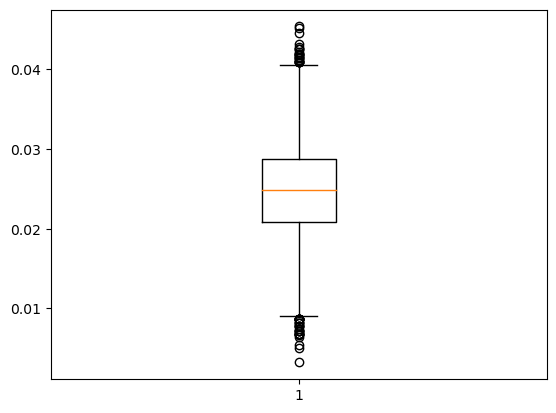

In [6]:
fig, ax = plt.subplots()
ax.boxplot(inner_values)
plt.show()

In [7]:
y_pred_full = np.array([l.predict_proba(X_test[:10**6]) for l in tqdm(clf[:n_trees_per_sample])])

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
y_pred_full.var(axis=0).sum(axis=1).var() / (n_trees_per_sample**2 * n_instances_per_sample)

3.2586303323953604e-05

# Conclusion
Confirmed